# More cost function features and VQE

This notebook showcases the more advanced features of our cost functions using the example of VQE. Since QAOA can be thought of as a special case of VQE everything said here applies also to the QAOA cost functions, unless otherwise explicitely mentioned.

### Contents
0. [Setting up VQE](#setup)
1. [Simulating sampling noise](#nshots)
2. [Getting the measurement variance](#scalar_cost_function)
3. [Logging of the optimization process](#enable_logging)
4. [Running on the QVM or QPU](#on_qvm)
4. [Towards QAOA](#towards_qaoa)
5. [Details for the statistics nerd](#statistics_details)

As with all the Demo Notebooks, you need to start the Simulator and the Quil Compiler in the background by typing `qvm -S` and `quilc -S` in two open and disposable terminal windows.

## Short Intro: The Variational Quantum Eigensolver (VQE)
Before we dive into it, we give a short reminder on the VQE. If you are already familiar with out, you may skip the next paragraph.

Let us begin with a very brief review of the Variational Quantum Eigensolver (VQE) to get the nomenclature sorted out. The aim of VQE is to find the ground state and/or ground state energy of a given cost hamiltonian $\hat{H}_\mathrm{cost}$. To do so, one prepares a trial state $\left| \psi (\vec{\gamma})\right> = \hat{U}(\vec{\gamma}) \left| 0 \right>$ by applying a parametric program $\hat{U}(\vec{\gamma})$ to the initial state $\left| 0 \right>$, and then measures its energy expectation value with respect to the cost Hamiltonian, $\left<\hat{H}_\mathrm{cost}\right>(\vec{\gamma}) = \left< \psi(\vec{\gamma}) \right|\hat{H}\left| \psi(\vec{\gamma})\right>$. This expectation value is then minimized by optimizing the parameters $\vec{\gamma}$ in a classical optimizer until a minimum of $\left<\hat{H}_\mathrm{cost}\right>(\vec{\gamma})$ is found for a parameter set $\vec{\gamma}^*$. The lowest energy eigenstate of $\hat{H_\mathrm{cost}}$ can now be prepared by applying $\hat{U}(\vec{\gamma}^*)$ to $\left| 0 \right>$, and its energy is given by $E_0 = \left< \psi(\vec{\gamma}^*) \right|\hat{H}_\mathrm{cost}\left| \psi(\vec{\gamma}^*)\right>$

Now it should also be clear, that QAOA can be considered as a special case of VQE where the Ansatz is fixed to be of the form

$$
\hat{U}(\vec{\beta}, \vec{\gamma})
    = e^{-i \beta_p H_M} e^{-i \gamma_p H_C}
      \cdots
      e^{-i \beta_0 H_M} e^{-i \gamma_1 H_C}
$$

with the free parameters $\vec{\beta}, \vec{\gamma}$.

Before we begin, let us first import all neccesary libraries:

In [69]:
# The usual combination of scipy, numpy and matplotlib
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# The pyquil dependencies
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.api import WavefunctionSimulator, get_qc
from pyquil.quil import Program
from pyquil.gates import RY, H
from pyquil.unitary_tools import lifted_pauli

# A finally the cost functions
from entropica_qaoa.vqe.cost_function import (PrepareAndMeasureOnWFSim,
                                              PrepareAndMeasureOnQVM,
                                              pauli_matrix)
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim

# And one our QAOA parameter classes
from entropica_qaoa.qaoa.parameters import StandardParams

<a id='setup'></a>

## Setting up the problem

We start by creating a cost hamiltonian `hamiltonian` and state preparation program `prepare_ansatz`:

In [70]:
# create the cost hamiltonian
hamiltonian = PauliSum([PauliTerm("X", 0)])

# and the parametric state preparation program:
prepare_ansatz = Program() # built an empty program
params = prepare_ansatz.declare("params", # add a classical register to store the values in 
                                memory_type="REAL", memory_size=1)
#prepare_ansatz.inst(H(0))
prepare_ansatz.inst(RY(params[0], 0))

print(prepare_ansatz)

DECLARE params REAL[1]
RY(params[0]) 0



Next we can create a cost function, which can be passed to a classical optimizer later. We do this by using `vqe.cost_function.PrepareAndMeasureOnWFSim`, a class that combines a cost hamiltonian `hamiltonian` and a state preparation circuit `prepare_ansatz` into a cost function that can be passed to any classical optimizer.

In [71]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian)

With the cost function set up, let us have a look at it graphically:

In [72]:
gammas = np.linspace(-3,2,200)
exp_vals = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals[i] = cost_fun([v])

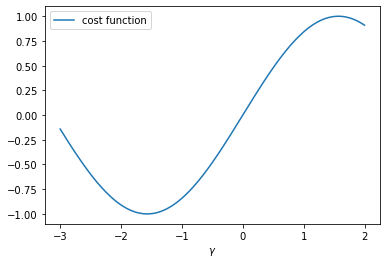

In [73]:
plt.plot(gammas, exp_vals, label="cost function")
plt.xlabel(r"$\gamma$")
plt.legend()
plt.show()

Now let us also go ahead and try to find the minimal function value and argument:

In [74]:
# the initial argument
gamma0 = [0]
# and minimization
out = minimize(cost_fun, gamma0, method="Cobyla")
print(out)

     fun: -0.9999999954355244
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([-1.57070078])


`out` should now contain the minimal eigenvalue of `hamiltonian` as the minimal function value and the correct parameters for `prepare_ansatz` to prepare the corresponding eigenstate. We can compare this with the real minimal eigenvalue, by printing `hamiltonian` as a matrix:

In [75]:
print("The output of scipy.optimize.minimize:\n",out)
print("\n And the eigenvalues of the hamiltonian:\n", np.linalg.eigvalsh(pauli_matrix(hamiltonian)))

The output of scipy.optimize.minimize:
      fun: -0.9999999954355244
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([-1.57070078])

 And the eigenvalues of the hamiltonian:
 [-1.  1.]


This looks good, it seems we found the ground state exactly. But on a real quantum computer we can't get the energy expectation value of a state directly. Instead we have to take samples and calculate their mean. Only if we take enough samples, that estimate will be accurate. To simulate this sampling noise the `PrepareAndMeasureOnWFSim` has an argument `nshots`

<a id='nshots'></a>

## Simulating sampling noise

Now let's do the more realistic case, where we don't get the exact expectation value but only an estimate of it based on `nshots` samples. To do that we need to create a new cost function that adds simulated sampling noise:

In [76]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    nshots = 5)

and plot it again, to see what changed:

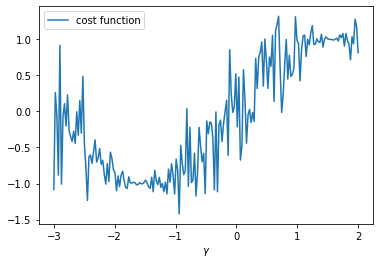

In [77]:
gammas = np.linspace(-3,2,200)
exp_vals = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals[i] = cost_fun([v])

plt.plot(gammas, exp_vals, label="cost function")
plt.xlabel(r"$\gamma$")
plt.legend()
plt.show()

Now this looks more like what we expected to see. We also observe, that around the minimum and maximum value the function is less fluctuating then in between. This is to be expected: At $\gamma = -\frac{\pi}{2}$ and $\gamma = \frac{\pi}{2}$ we prepare exactly an eigenstate of our hamiltonian, hence the variance there is 0. To get more informations, what the variance at given parameters is, we can use the `scalar_cost_function = False` argument:

<a id='scalar_cost_function'></a>

## Getting the measurement variance

If we set the flag `scalar_cost_function=False` in the constructor of the cost functions, it changes from returning the simulated sample mean to returning a tuple containing the simulated sample mean and its standard deviation. If we specify a sample size of `nshots=0` it sets the standard deviation to 0 and adds no noise to the mean and sets the standard deviation to 0, so this case corresponds to `nshots = infty`.

So here is above code again, with the flag `scalar_cost_function=False`:

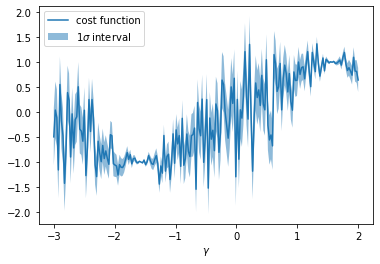

In [78]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    nshots = 3,
                                    scalar_cost_function=False)

# get the means and standard deviations
gammas = np.linspace(-3,2,200)
exp_vals = np.empty_like(gammas)
std_devs = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals[i], std_devs[i] = cost_fun([v])

# and plot both
plt.plot(gammas, exp_vals, label="cost function")
plt.fill_between(gammas, exp_vals - std_devs, exp_vals + std_devs,
                 label=r"$1\sigma$ interval", alpha=0.5)
plt.xlabel(r"$\gamma$")
plt.legend()
plt.show()

   __**Note**__
   
You might have noticed, that sometimes the sample mean lies outside of the [-1, 1] interval, even though these are the minimum and maximum eigenvalues. This is due to the way we calculate the sampling noise and happens much less for larger, more realistic sample numbers. More details are [in the last chapter](#statistics_details)


<a id='enable_logging'></a>

## Logging of the optimization process

For debugging and benchmarking purposes it is often interesting to see, how the optimization progresses and at which arguments the cost function gets called. So we included the possibility to have the cost function log each of its calls and write the argument and function value there to `cost_function.log`. Because `scipy.optimize.minimze` expects the cost function to return a scalar, we have to set the flag `scalar_cost_function = True`, except for that not much changes in the previous code:

In [79]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    nshots = 10,
                                    scalar_cost_function = True,
                                    enable_logging = True)

# and find the optimal value
gamma0 = [0]
# and minimization
out = minimize(cost_fun, gamma0, method="Cobyla")
print(out)

     fun: -1.000459916060095
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 21
  status: 1
 success: True
       x: array([-1.56337656])


We see, that this time we didn't find the correct miminum value, most likely due to the added sampling noise and very low sample number. Let us have a look at the optimisation log:

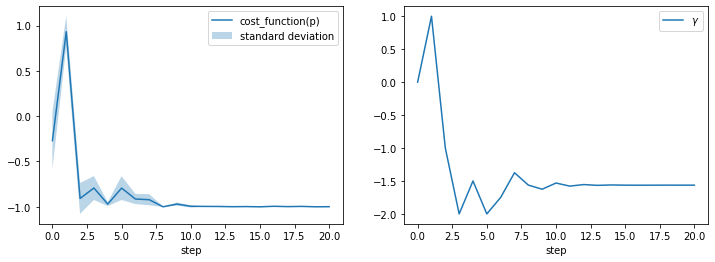

In [80]:
# extract gamma and function value for each of the function calls in the log
gamma_log = np.array([step.x for step in cost_fun.log])
fun_log = np.array([step.fun for step in cost_fun.log])

# create an array for the x-axis:
x = np.arange(out["nfev"])

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x, fun_log[:,0], label="cost_function(p)")
ax[0].fill_between(x, fun_log[:,0] - fun_log[:,1], fun_log[:,0] + fun_log[:,1],
                   alpha=0.3, label="standard deviation")
ax[0].legend()
ax[0].set_xlabel("step")

ax[1].plot(x, gamma_log, label=r"$\gamma$")
ax[1].legend()
ax[1].set_xlabel("step");

and we see, that it was indeed the large standard deviation due to the small sample number, that stopped us from converging further. Try to experiment with different values for `n_shots`.

<a id='on_qvm'></a>

## Running on the QVM or QPU

So far, we ran all our experiments on the wavefunction simulator. But eventually you might also want to run them on the the QVM or even on Rigettis real quantum computers. These don't return you a wavefunction, so you _have to_ estimate your energy expectation values from samples and also the standard deviation can only be estimated from samples. So the argument `nshots` is now compulsory and the inner workings of the cost functions are slightly different. Hence we provide more cost function constructors `PrepareAndMeasureOnQVM` (for general VQE) and `QAOACostFunctionOnQVM` (for QAOA) for this case. They behave mostly identical to  `PrepareAndMeasureOnQVM` and `QAOACostFunctionOnQVM` with a few differences:

 - You have to pass an argument `qvm` which is either an identification string for a QVM type
   like `2q-qvm`
   (see [Rigettis docs](http://docs.rigetti.com/en/latest/apidocs/quantum_computer.html))
   or a connection to a QVM or QPU
   (see also [Rigettis docs](http://docs.rigetti.com/en/latest/apidocs/quantum_computer.html))
 - There is an argument `base_numshots` that acts as a multiplier of `nshots`. It gets hard 
   compiled into the circuit, whereas `nshots` can be changed dynamically during the
   optimization (if you write an optimizer that can do this). This might be of interest for
   people looking into more sophisticated optimizers.
   
So let us go through above example again, only this time running on the QVM:

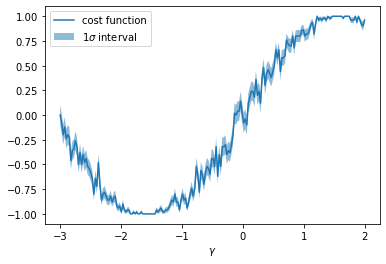

In [81]:
# this time we really need a QVM
qvm = get_qc("2q-qvm")

# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnQVM(prepare_ansatz=prepare_ansatz,
                                  make_memory_map=lambda p: {"params": p},
                                  hamiltonian=hamiltonian,
                                  qvm = qvm,
                                  base_numshots = 100,
                                  nshots = 1,
                                  scalar_cost_function=False)

# get the means and standard deviations
gammas = np.linspace(-3,2,200)
exp_vals = np.empty_like(gammas)
std_devs = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals[i], std_devs[i] = cost_fun([v])

# and plot both
plt.plot(gammas, exp_vals, label="cost function")
plt.fill_between(gammas, exp_vals - std_devs, exp_vals + std_devs,
                 label=r"$1\sigma$ interval", alpha=0.5)
plt.xlabel(r"$\gamma$")
plt.legend()
plt.show()

<a id='towards_qaoa'></a>

## Towards QAOA

A more detailled explanation of our QAOA library can be found in the Notebooks `QAOAWorkflowDemo.ipynb` and `QAOAParameterDemo.ipynb`. Here we only explain how it can be regarded as a special case of VQE.

For QAOA - which was originally designed for solving classical optimization problems - the Hamiltonian is diagonal in the computational basis, and typically contains at most 2-qubit terms (there is nothing to prevent one from considering k-qubit terms, however the limitations of near-term hardware make the k = 2 case the most practically feasible). 

In [37]:
hamiltonian = []
hamiltonian.append(PauliTerm("Z", 0, -1)*PauliTerm("Z", 1))
hamiltonian.append(PauliTerm("Z", 0, 0.8))
hamiltonian.append(PauliTerm("Z", 1, -0.5))
hamiltonian = PauliSum(hamiltonian)
print(hamiltonian)

(-1+0j)*Z0*Z1 + (0.8+0j)*Z0 + (-0.5+0j)*Z1


Since the parameters for a QAOA circuit have more structure than just a flat array, and there exist multiple possible parametrizations, we provide special classes to hold the parameters for a QAOA circuit. We will use the `StandardParams` class here. We can create these initial parameters like this:

Also, there exists an educated guess for good initial parameters, depending on the Hamiltonian.

In [50]:
params = StandardParams.linear_ramp_from_hamiltonian(hamiltonian, n_steps=5)

The QAOA cost function has a fixed structure, with a corresponding fixed state preparation program. We therefore provide special cost functions for QAOA, which inherit most of the behaviour from `vqe.cost_functions.PrepareAndMeasure...`. They are created via

In [51]:
qaoa_cost_fun = QAOACostFunctionOnWFSim(hamiltonian,
                                        params,
                                        sim,
                                        scalar_cost_function=True,
                                        nshots=1000,
                                        enable_logging=True)

Unlike for `PrepareAndMeasureOnWFSim`, we didn't have to pass a state preparation circuit `prepare_ansatz` or function to generate memory maps `make_memory_map` to `QAOACostFunctionOnWFSim`. These are already fixed by the fact that we want to do QAOA on a given hamiltonian. Instead we had to pass the QAOA parameters `parameters` to it.

If we want to find the optimal parameters, we have to provide our optimizer with some initial parameter set. Currently our `params` are of type `StandardParameters`, which is not something that `scipy.optimize.minimize` recognizes. We can obtain a `np.array` with all of our parameters in a 1D array using the `params.raw()` method, and then pass these to `scipy.optimize.minimize`:

In [52]:
p0 = params.raw()
out = minimize(qaoa_cost_fun, p0, tol=1e-3, method="Cobyla", options={"maxiter": 500})

In [53]:
print("The output of scipy.optimize.minimize:\n",out)
print("\n And hamiltonian as a matrix:\n", lifted_pauli(hamiltonian, hamiltonian.get_qubits()))

The output of scipy.optimize.minimize:
      fun: -0.8892765439231967
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 69
  status: 1
 success: True
       x: array([0.62694774, 0.49291633, 0.34158072, 0.18972611, 0.06810073,
       0.07567067, 0.21805351, 0.36161781, 0.49396123, 0.63915879])

 And hamiltonian as a matrix:
 [[-0.7+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.3+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  2.3+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -1.3+0.j]]


So we got close again, but not exactly there. If we want to have a look at the logs this time, it is a little more complicated. Our logging functionality simply appends the array of current parameters to the log. If we want to have them in terms of `betas` and `gammas` again, we can pipe them through the `params` instance again:

In [54]:
betas_log = []
gammas_log = []
for step in qaoa_cost_fun.log:
    params.update_from_raw(step.x)
    betas_log.append(params.betas)
    gammas_log.append(params.gammas)
betas_log = np.array(betas_log)
gammas_log = np.array(gammas_log)
    
fun_log = np.array([step.fun for step in qaoa_cost_fun.log])

# create an array for the x-axis:
x = np.arange(out["nfev"])

And now we can plot them;

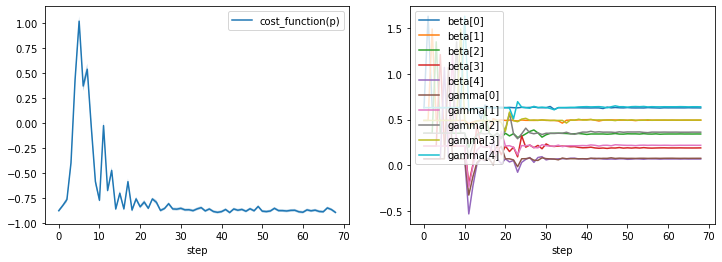

In [56]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x, fun_log[:,0], label="cost_function(p)")
ax[0].fill_between(x, fun_log[:,0] - fun_log[:,1], fun_log[:,0] + fun_log[:,1], alpha=0.3)
ax[0].legend()
ax[0].set_xlabel("step")

for i in range(5):
    ax[1].plot(x, betas_log[:,i], label=f"beta[{i}]")
for i in range(5):
    ax[1].plot(x, gammas_log[:,i], label=f"gamma[{i}]")
ax[1].legend()
ax[1].set_xlabel("step");

### TODO: FIX THE FORMATTING HERE ###

We can also only plot the final, optimal parameters with the built-in `params.plot()` function:

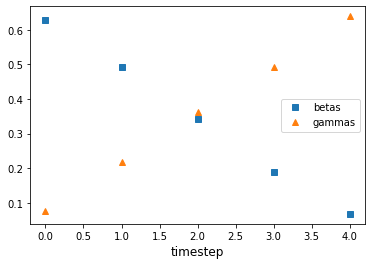

In [57]:
params.update_from_raw(out["x"])
params.plot()

<a id='statistics_details'></a>

## Implementation Details for the Statistics Nerd

The attentive observer will have noticed that we sometimes get function values below the minimal eigenvalue of the hamiltonian and then wondered, how we get this unphysical result. This is, because we "fake" the sampling noise when using the wavefunction based cost functions `PrepareAndMeasureOnWFSim` and `QAOACostFunctionOnWFSim`. We first calculate the true energy expectation value and variance via

$$
E(\vec{\gamma}) = \left<\psi(\vec{\gamma})\left| \hat{H} \right| \psi(\vec{\gamma})\right>
\qquad\mathrm{and}\qquad
\mathrm{var}(E)(\vec{\gamma}) = \left<\psi(\vec{\gamma})\left| \hat{H}^2 \right| \psi(\vec{\gamma})\right> - \left<\psi(\vec{\gamma})\left| \hat{H} \right| \psi(\vec{\gamma})\right>^2
$$

and then return, in accord with the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), this energy expectation value plus appropriately scaled gaussian noise and the standard deviation of the mean:

$$
\mathrm{cost\_function} (\vec{\gamma}) =
\left(
    E(\vec{\gamma}) +  \mathcal{N}\left(0, \sqrt{\frac{\mathrm{var}(E)(\vec{\gamma})}{\mathrm{nshots}}}\right),
\sqrt{\frac{\mathrm{var}(E)(\vec{\gamma})}{\mathrm{nshots}}}
\right)
$$

Now in the above case we used extremely small numbers of shots `n = 3` or `n = 20`, in which the central limit theorem doesn't really hold. Hence we get these unphysical results. But for more realistic cases one would take much larger numbers of shots to get acceptable results anyways.

On the other hand, the sampling based cost functions `PrepareAndMeasureOnQVM` and `QAOACostFunctionOnQVM` don't need to fake sampling noise and you are guaranteed to get physical results. This comes at the cost of much slower simulations, because a lot of random numbers have to be generated.